# PCA

In [103]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

data = pd.read_parquet("data/processed_dataset.parquet")

In [118]:
# Update predictors list
meta_cols = ['Season', 'Date', 'Date.1', 'OU-Cover', 'OU', 'Target', 'TEAM_NAME', 'TEAM_NAME.1']
predictors = [col for col in data.columns if col not in meta_cols]

predictors_df = data[predictors]
target = data['Target']

# Standardize the features first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(predictors_df)


In [119]:
# Set random seed for reproducibility
np.random.seed(42)

# Create cross-validation splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [120]:

# Initialize lists to store results
cv_scores = []
cv_n_components = []
cv_feature_importance = []

for fold, (train_idx, val_idx) in tqdm(enumerate(kf.split(X_scaled)), total=n_splits, desc="Cross-validation"):
    # Split the data
    X_train = X_scaled[train_idx]
    X_val = X_scaled[val_idx]
    y_train = target.iloc[train_idx]
    y_val = target.iloc[val_idx]
    
    # Fit PCA with 95% explained variance
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    
    # Store number of components needed for 95% variance
    cv_n_components.append(pca.n_components_)
    
    # Train Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train_pca, y_train)
    
    # Calculate validation score
    val_score = clf.score(X_val_pca, y_val)
    cv_scores.append(val_score)
    
    # Store feature importance
    cv_feature_importance.append(np.abs(pca.components_))
    
    print(f"Fold {fold + 1}:")
    print(f"Number of components for 95% variance: {pca.n_components_}")
    print(f"Validation accuracy: {val_score:.4f}\n")



Cross-validation:  20%|██        | 1/5 [00:01<00:06,  1.54s/it]

Fold 1:
Number of components for 95% variance: 40
Validation accuracy: 0.6398



Cross-validation:  40%|████      | 2/5 [00:02<00:04,  1.46s/it]

Fold 2:
Number of components for 95% variance: 40
Validation accuracy: 0.6345



Cross-validation:  60%|██████    | 3/5 [00:04<00:02,  1.40s/it]

Fold 3:
Number of components for 95% variance: 40
Validation accuracy: 0.6421



Cross-validation:  80%|████████  | 4/5 [00:06<00:01,  1.64s/it]

Fold 4:
Number of components for 95% variance: 40
Validation accuracy: 0.6480



Cross-validation: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]

Fold 5:
Number of components for 95% variance: 40
Validation accuracy: 0.6371



In [121]:
# Calculate and print average results
avg_n_components = np.mean(cv_n_components)
avg_score = np.mean(cv_scores)
std_score = np.std(cv_scores)

print(f"Average number of components needed for 95% variance: {avg_n_components:.1f}")
print(f"Average validation accuracy: {avg_score:.4f} ± {std_score:.4f}")

# Calculate and store average feature importance
avg_feature_importance = np.mean(cv_feature_importance, axis=0)
total_importance = np.sum(avg_feature_importance, axis=0)
feature_importance_dict = dict(zip(predictors, total_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Save top features to DataFrame
top_features_df = pd.DataFrame(sorted_features[:40], columns=['Feature', 'Importance'])
top_features_list = top_features_df['Feature'].tolist()

Average number of components needed for 95% variance: 40.0
Average validation accuracy: 0.6403 ± 0.0046


In [122]:
# Fit final PCA and transform data
final_pca = PCA(n_components=0.95)
X_pca_final = final_pca.fit_transform(X_scaled)

# Create visualizations
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

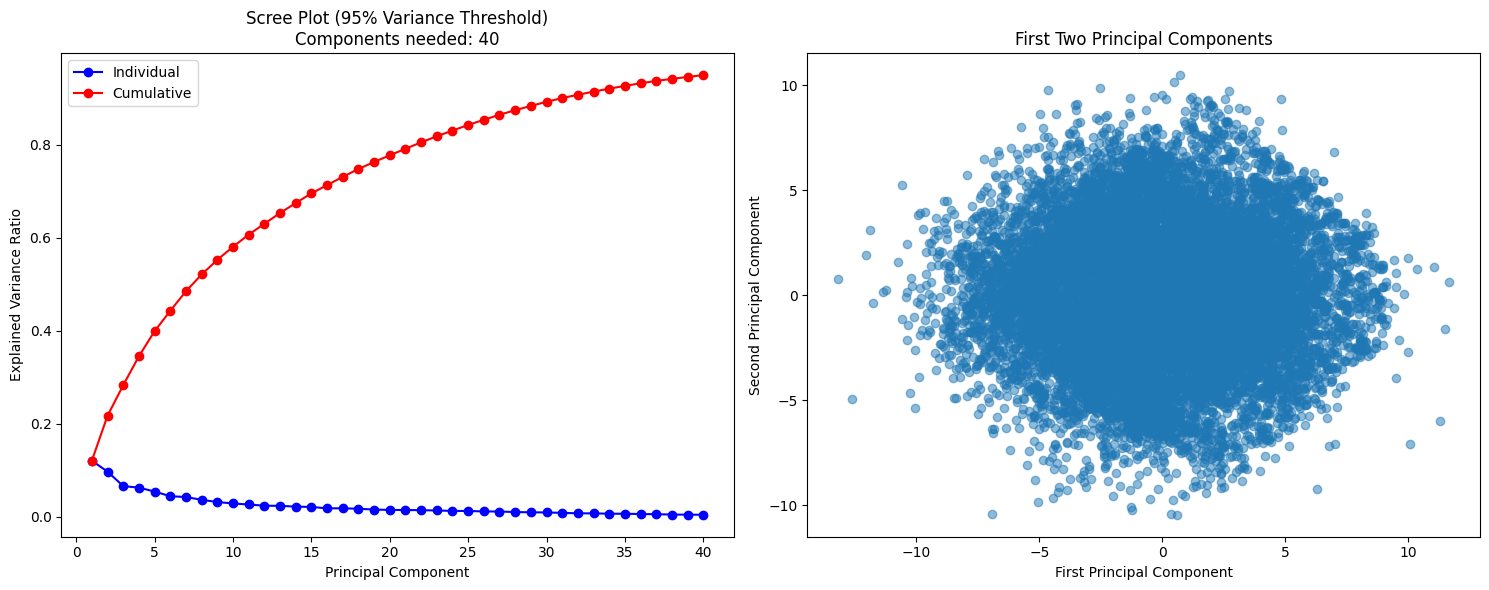

In [123]:
# create a wider figure
plt.figure(figsize=(15, 6))

# Scree plot
plt.subplot(1, 2, 1)
explained_variance_ratio = final_pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Scree Plot (95% Variance Threshold)\nComponents needed: {final_pca.n_components_}')
plt.legend(['Individual', 'Cumulative'])

# First two principal components
plt.subplot(1, 2, 2)
plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')

plt.tight_layout()
plt.show()

# Save the final PCA model and transformed data
final_pca_data = pd.DataFrame(
    X_pca_final, 
    columns=[f'PC{i+1}' for i in range(final_pca.n_components_)]
)

# Save top features to a list for future use
top_features = top_features_df['Feature'].tolist()

In [124]:
# save 
df_top_features = data[top_features_list + meta_cols]
df_top_features.to_parquet("data/top_features.parquet")